## In this Notebook we will try to implement the linear regression with the help of 3 techniques.
### 1.Using Normal Equations.
### 2.Using Sklearn Library.
### 3.Using Manual Code to implement Batch Gradient Descent.

In [177]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from tabulate import tabulate_formats ,tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from sklearn.preprocessing import StandardScaler ,Normalizer
from collections import Counter
from sklearn.datasets import load_boston


In [178]:
data=load_boston()
columns=list(data.feature_names)
columns.append('PRICE')
X=data.data
Y=data.target
df_n=np.hstack((X,Y.reshape(-1,1)))
final_df=pd.DataFrame(data=df_n,columns=columns)
final_df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [179]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33)

In [180]:
print("dataset sizes after split")
print("Train set:{}  Test Set{}".format(X_train.shape,X_test.shape))

dataset sizes after split
Train set:(339, 13)  Test Set(167, 13)


In [181]:
std=StandardScaler(with_mean=True)
std.fit(X_train)
X_train=std.transform(X_train)
X_test=std.transform(X_test)

In [182]:
def pls(prdtr,prdts,clasf):
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.title("predicted price vs actual price for "+str(clasf))
    plt.xlabel("actual price")
    plt.ylabel("predicted price")
    plt.scatter(Y_train,prdtr,label="train data",c='orange')
    plt.scatter(Y_test,prdts,label="test data",c='blue')
    plt.legend()
    return plt

### 1.Normal Equations to Find The optimal Parameter.

###   <p style="color:grey;font-size:15px">1.1 Below Procedure is just 1 step to calculate for the optimal parameter.</p>
<ol>
<li>suppose my training data is having 'n' training examples and each training example is having d features.</li><br>
<li>X denotes the train data matrix where $X\in R^{\;n\;*(d+1)}$ where we have added 1 redundant feature to the starting of our train data containing all 1's.</li><br>
<li>Y will be a vector denoting the real valued outputs for training set $Y\in R^{n}$</li><br>
<li>$\theta$ is the optimal parameter that we have to model/learn during training and $\theta\in R^{d+1}$.</li><br>
<li>Hypothesis/Prediction Function will be $h_{\theta}(X_{i})=\theta^{T}X_i$ where $X_{i}$ denote 1 example.</li><br>
<li>Loss function will be:<br> <p style="color:black;font-size:20px">$J(\theta)=\frac{\sum_{i=1}^{n}(h_{\theta}(X_{i})-y^(i))^2}{2}$ = $\frac{(X\theta-Y)(X\theta-Y)^{T}}{2}$</p></li><br>
<li>The J($\theta$) is a convex function so it has only 1 optimim minima that can be found out by differentiating the Loss w.r.t. $\theta$ and equating it to 0.</li><br>
<li>So after differentiation  $\theta$ comes out to be $\theta_{optimum}=(X^{T}X)^{-1}X^{T}Y$</li>
</ol>

In [183]:
#Appending the extra column to the train data and test data:
X_tr_N=np.hstack((np.full((X_train.shape[0],1),1),X_train))
X_ts_N=np.hstack((np.full((X_test.shape[0],1),1),X_test))
print("shapes : Train {} Test {}".format(X_tr_N.shape,X_ts_N.shape) )

shapes : Train (339, 14) Test (167, 14)


In [184]:
p2=np.matmul(np.transpose(X_tr_N),Y_train)
p1=np.linalg.inv(np.matmul(np.transpose(X_tr_N),X_tr_N))

theta=np.matmul(p1,p2)

In [185]:
#predicting outputs for train and test data.
y_tr_Np=np.matmul(X_tr_N,theta)
y_ts_Np=np.matmul(X_ts_N,theta)

print("train MSE:{} \nTest MSE:{}".format(mean_squared_error(y_tr_Np,Y_train),mean_squared_error(y_ts_Np,Y_test)))

train MSE:25.17325304096817 
Test MSE:16.92013333119316


### 2.Implementing with sklearn.linear_model.SGDRegressor with Hyperparameter Tuning.

<ol>
<li>Hypothesis Function is given by <p>$h_{\theta}(X_{i})=\theta^{T}X_i+\theta_{0}$</p><br></li>
<li>Here $\theta\in R^{d}\;and \;\theta_{o}\in R. \theta_0 $is the intercept.</li><br>
<li>The Loss function we are minimizing is OLS (Ordinary Least Squares).<br><p style="color:black;font-size:20px">$J(\theta)=\frac{\sum_{i=1}^{n}(y^{(i)}-(\theta^TX_{i}+\theta_0))^2}{2}+\alpha*Regularizer(L1/L2)$</p><br></li>
<li>We have to learn both $\theta$ and $\theta_0$ during Training with hyperparameter tuning of $\alpha$ and regularization.</li>
</ol>

In [199]:
def HT(gdclf,grid):
    fig,ax=plt.subplots(1,2,figsize=(18,7))
    ax[0].set_title("mean_squared error vs alpha for l1 penalty")
    ax[0].set_xlabel("log(alpha)")
    ax[0].set_ylabel("mean suqred error")
    sns.lineplot(x=np.log(grid['alpha']),y=-1*gdclf.cv_results_['mean_train_score'][0::2],\
                 palette='viridis',ax=ax[0],label='train')
    sns.scatterplot(x=np.log(grid['alpha']),y=-1*gdclf.cv_results_['mean_train_score'][0::2],ax=ax[0])
    sns.lineplot(x=np.log(grid['alpha']),y=-1*gdclf.cv_results_['mean_test_score'][0::2],\
                 palette='viridis',ax=ax[0],label='cv')

    ax[1].set_title("mean_squared error vs alpha for l2 penalty")
    ax[1].set_xlabel("log(alpha)")
    ax[1].set_ylabel("mean suqred error")
    sns.lineplot(x=np.log(grid['alpha']),y=-1*gdclf.cv_results_['mean_train_score'][1::2],palette='viridis',\
                 ax=ax[1],label='train')
    sns.lineplot(x=np.log(grid['alpha']),y=-1*gdclf.cv_results_['mean_test_score'][1::2],palette='viridis'\
                 ,ax=ax[1],label='cv')
    

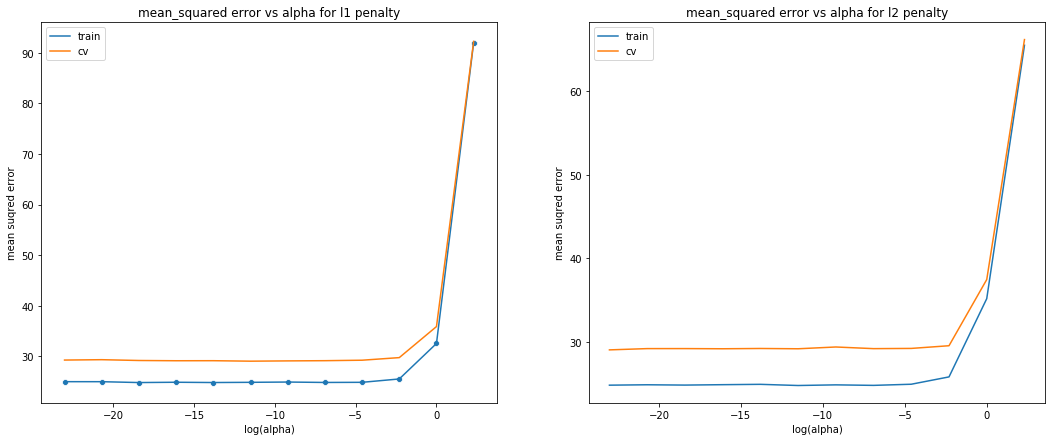

In [207]:
#GridSearchCV with 4-FOLD cross validation with score as negative of mean squared error
grid={'alpha':[10**(i-10) for i in range(12)], 'penalty':['l1','l2']}
gdclf=GridSearchCV(SGDRegressor(loss='squared_loss',fit_intercept=True),param_grid=grid,cv=4\
                   ,scoring='neg_mean_squared_error',return_train_score=True)
gdclf.fit(X_train,Y_train)
HT(gdclf,grid)

In [188]:
print("BEST HYPERPARAMETER:")
print(gdclf.cv_results_['params'][np.argmax(gdclf.cv_results_['mean_test_score'])])
htclf=SGDRegressor(loss='squared_loss',fit_intercept=True,alpha=0.0001,penalty='l1',verbose=0)
htclf.fit(X_train,Y_train)

BEST HYPERPARAMETER:
{'alpha': 0.0001, 'penalty': 'l1'}


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [189]:
ytr_htpred=htclf.predict(X_train)
yts_htpred=htclf.predict(X_test)

print("MSE ON Train DATA "+str(mean_squared_error(Y_train,ytr_htpred)))
print("MSE ON Test DATA "+str(mean_squared_error(Y_test,yts_htpred)))


MSE ON Train DATA 25.288843972044393
MSE ON Test DATA 16.47181215098596


### 3.Batch Gradient Descent Over the data to obtain the optimum parameters.

<ol>
<li>Here For Simplicity we have removed the regularization term from the loss equation.</li><br>
<li>The Loss function we are minimizing is MSE(mean squared error.)<br><p style="color:black;font-size:20px">$argmin_{(\theta,\theta_0)}J(\theta,\theta_0)=\frac{\sum_{i=1}^{n}(y^{(i)}-(\theta^TX_{i}+\theta_0))^2}{n}$</p><br></li>
<li>Here $\theta\in R^{d}\;and \;\theta_{o}\in R. \theta_0 $is the intercept. $\eta$ is the learning rate.</li><br>
<li>We have to learn both $\theta$ and $\theta_0$ during Training.</li><br>
<li>We have the partial derivative of the Loss function with respect to parameters as<br><p style="color:black;font-size:20px">$\frac{\partial J(\theta,\theta_0)}{\partial\theta}=-\frac{2}{n}*(y^{(i)}-(\theta^TX_{i}+\theta_0))*X_{i};$<br><br>$\frac{\partial J(\theta,\theta_0)}{\partial\theta_0}=\frac{2}{n}*(y^{(i)}-(\theta^TX_{i}+\theta_0));$</p><br></li>
<li>We will use the convergence equation of the batch gradient descent to update our parameters:<br><p style="color:black;font-size:20px">$\theta^{i}=\theta^{i-1}+\eta*\frac{\partial J(\theta,\theta_0)}{\partial\theta^{i-1}}$<br><br>
    $\theta_0^{i}=\theta_0^{i-1}+\eta*\frac{\partial J(\theta,\theta_0)}{\partial\theta_0^{i-1}}$</p></li>
<p>$\theta^{i}$ is the value of $\theta$ for iteration i.</p>
</ol>

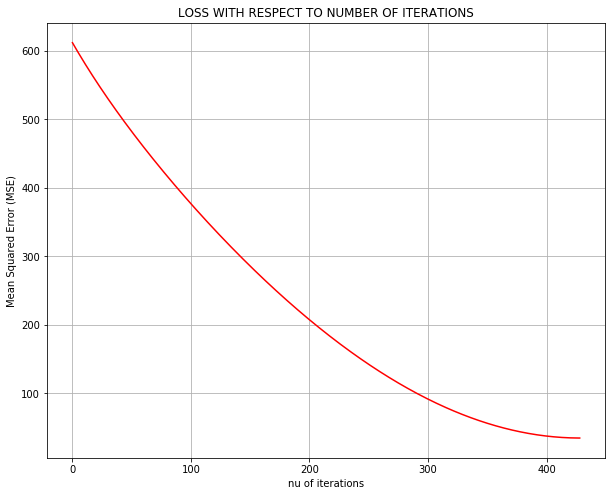

Train error :34.73408732090314
Test error :19.061824628453905


In [191]:
itr=0
J=[]
#initializing the variables randomly

#initializing the learning rate...
lear_rate=0.001

#initializing the theta with all zeros
theta=np.full((X_train.shape[1],1),0.0)

#initializing the theta_0 with 0.0
theta_0=0.0

mse_old=999999999

max_itr=10000
while True:
    
    MSE=np.average((np.square((np.matmul(X_train,theta)+theta_0)-Y_train.reshape(-1,1))))
    
    #Loop until my MSE is improving....
    if(mse_old<MSE or itr>max_itr):
        break
    
    #calculating the partial derivatives...
    pd_theta=-2*np.average(X_train*(Y_train.reshape(-1,1)-np.matmul(X_train,theta)+theta_0),axis=0).reshape(-1,1)
    pd_theta_0=-2*np.average(Y_train.reshape(-1,1)-np.matmul(X_train,theta)+theta_0)
    
    #updating the parameters...
    theta=theta-lear_rate*pd_theta
    theta_0=theta_0-lear_rate*pd_theta_0
    J.append(MSE)
    mse_old=MSE
    
    #decreasing the learning rate..
    lear_rate/=1.001
    itr+=1
    
plt.figure(figsize=(10,8))
plt.grid()
plt.title("LOSS WITH RESPECT TO NUMBER OF ITERATIONS")
plt.plot(np.arange(itr),J,color='r')
plt.xlabel("nu of iterations")
plt.ylabel("Mean Squared Error (MSE)")
plt.show()

#Prediction for the test data points
Y_trpred=np.matmul(X_train,theta)+theta_0
Y_tspred=np.matmul(X_test,theta)+theta_0
print("Train error :{}".format(mean_squared_error(Y_train,Y_trpred)))
print("Test error :{}".format(mean_squared_error(Y_test,Y_tspred)))


### 4.Prediction Performance Of  3 Models.

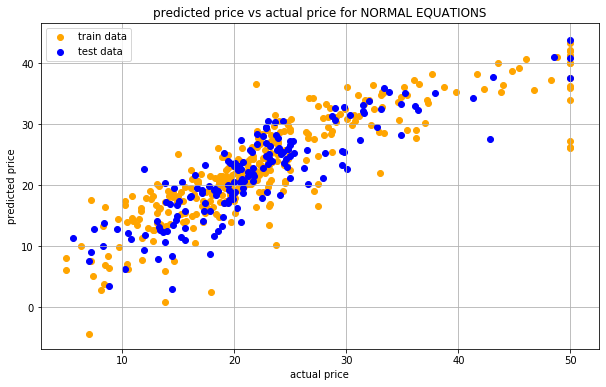

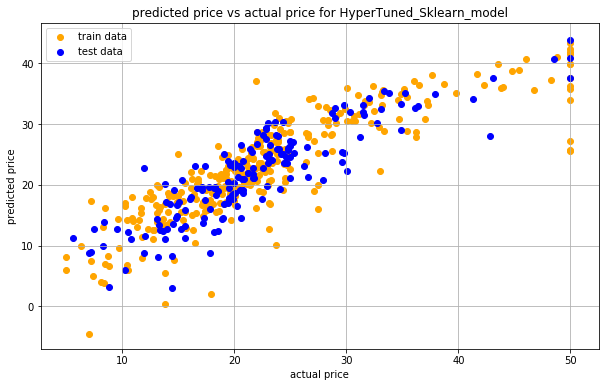

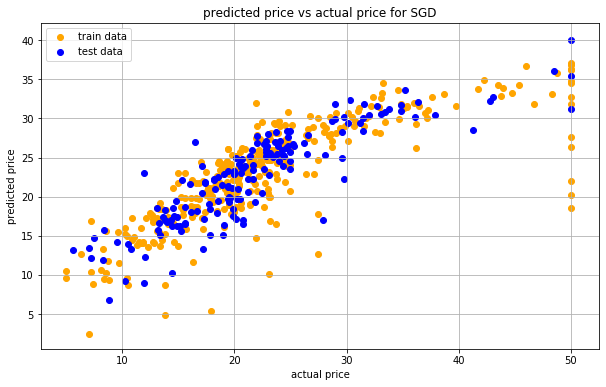

In [198]:
pls(y_tr_Np,y_ts_Np,"NORMAL EQUATIONS")
pls(ytr_htpred,yts_htpred,"HyperTuned_Sklearn_model")

pls(Y_trpred,Y_tspred,"SGD")
plt.show()

<p>Using Normal Equations and sklearn implementation the Errors are same ,But for the SGD implementation it is a little different.It may be because of the initializations of $\theta \; , \,\theta_0\;and \;\eta$ .</p>

### 5.Summary Of the results:

In [152]:
summary=[['Normal Equations',\
    mean_squared_error(y_tr_Np,Y_train),mean_squared_error(y_ts_Np,Y_test)],\
  ['sklearn.SGDRegressor with hyperparameter tuning',\
   mean_squared_error(Y_train,ytr_htpred),mean_squared_error(Y_test,yts_htpred)],
 ['Gradient Descent',mean_squared_error(Y_train,Y_trpred),mean_squared_error(Y_test,Y_tspred)]]

headers = ["MODEL","Train_MSE","Test_MSE"]

print(tabulate(summary, headers, tablefmt='grid'))

+-------------------------------------------------+-------------+------------+
| MODEL                                           |   Train_MSE |   Test_MSE |
+=================================================+=============+============+
| Normal Equations                                |     19.3043 |    29.9751 |
+-------------------------------------------------+-------------+------------+
| sklearn.SGDRegressor with hyperparameter tuning |     20.2807 |    28.3227 |
+-------------------------------------------------+-------------+------------+
| Gradient Descent                                |     27.3067 |    35.4713 |
+-------------------------------------------------+-------------+------------+
